In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
#To use double-precision numbers: https://jax.readthedocs.io/en/latest/notebooks/Common_Gotchas_in_JAX.html
from jax.config import config
config.update("jax_enable_x64", True)

In [40]:
from patch_gnn.data import load_ghesquire
import pandas as pd
from pyprojroot import here
import pickle as pkl
from patch_gnn.splitting import train_test_split
from jax import random, vmap, nn
from patch_gnn.seqops import one_hot
from patch_gnn.graph import graph_tensors,stack_feature_tensors,prep_adjacency_matrix
from patch_gnn.layers import concatenate_node_features,get_norm_attn_matrix, MessagePassing
from patch_gnn.models import MPNN, DeepMPNN
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import explained_variance_score as evs
import matplotlib.pyplot as plt 
from sklearn.metrics import mean_squared_error as mse
import pickle as pkl
from patch_gnn.graph import met_position
import jax.numpy as jnp
import numpy as np
import networkx as nx

pd.set_option('display.max_rows', 100)
from jax.config import config 
config.update("jax_debug_nans", True)

#### The goal for this notebook is to explore adjacency matrix, such to see if the current implementation has "myself + my neighbors"

In [4]:
data = load_ghesquire()

graph_pickle_path = here() / "data/ghesquire_2011/graphs.pkl"
processed_data_path = here() / "data/ghesquire_2011/processed_data.pkl"

with open(graph_pickle_path, "rb") as f:
    graphs = pkl.load(f)

# the cleaned data has everything processed and ready to be used for deep learning
with open(processed_data_path, "rb") as f:
    processed_data = pkl.load(f)
    
key = random.PRNGKey(490)

In [5]:
# select the graphs that only exist in fitered dataset
# one cannot directly loop through the dict keys, and delete certain ones b/c it is changing 
graphs_to_remove = []
for graph_key in graphs.keys():
    if graph_key not in processed_data["accession-sequence"].tolist():
        print(graph_key)
        graphs_to_remove.append(graph_key)
for graph_key in graphs_to_remove:
    graphs.pop(graph_key)
print(f"the filtered graphs has {len(list(graphs.values()))} graphs")

Q8IXH7-MFTSMDPPPVELIR
P00492-VFIPHGLIMDR
O75874-LIDDMVAQAMK
P67936-MEIQEMQLK
the filtered graphs has 359 graphs


### Convert inputs to (n_graph, max_num_node, num_features)
forget about sasa and fluc features for a sec

In [9]:
train_df, test_df = train_test_split(key, processed_data)
len(train_df), len(test_df)

(251, 108)

In [10]:
train_graph = graph_tensors(train_df, graphs)
test_graph = graph_tensors(test_df, graphs)
train_target = train_df['ox_fwd_logit'].values
test_target = test_df['ox_fwd_logit'].values

In [11]:
adj_matrix, feature_matrix = train_graph
adj_matrix.shape, feature_matrix.shape

((251, 20, 20, 1), (251, 20, 67))

In [19]:
#graphs

In [34]:
adjs = []
acc = 'Q9H0U4-MGPGAASGGERPNLK'
g = graphs[acc]
a = nx.adjacency_matrix(g).todense() 
a = nx.adjacency_matrix(g).todense()  + np.eye(len(g))  ### the np.eye(len(g)) used to be commented out
a = np.expand_dims(np.array(a), 2)
a = prep_adjacency_matrix(a, 20)
adjs.append(a)
adjs = np.stack(adjs)

In [39]:
pd.DataFrame(np.squeeze(adjs))

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [30]:
a1

matrix([[1., 0., 1., 1., 1., 0.],
        [0., 1., 1., 0., 1., 0.],
        [1., 1., 1., 1., 1., 1.],
        [1., 0., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1., 0.],
        [0., 0., 1., 0., 0., 1.]])

In [43]:
from jax.random import PRNGKey
mpnn_init, mpnn_apply = MessagePassing()
output_shape, params = mpnn_init(PRNGKey(42), input_shape =( 20, 67,1) )
result = mpnn_apply(params, (adj_matrix[0,:,:,:], feature_matrix[0,:,:]))

In [46]:
pd.DataFrame(result)

,0,1,2,3,4,5,6,7,8,9,...,57,58,59,60,61,62,63,64,65,66
0,0.341086,1.377809,1.047194,0.858699,22.290280,0.149599,2.430987,0.213927,0.852715,3.237327,...,0.222903,0.359038,0.362030,14.062324,0.693772,0.347134,0.707834,0.861998,0.116400,0.033776
1,0.688156,2.837897,2.094389,1.762279,41.887774,0.598397,5.632410,0.233375,1.630631,6.088687,...,0.611861,1.136954,1.253641,28.423847,1.075634,0.571476,1.134471,1.787758,0.199459,0.060999
2,1.753303,7.143362,5.235972,4.443096,94.995489,2.393587,13.444480,0.339590,4.832054,12.397285,...,1.210257,4.248617,4.393728,64.327654,2.079180,1.545808,2.412281,4.601232,0.587024,0.168401
3,0.688156,2.837897,2.094389,1.762279,41.887774,0.598397,5.632410,0.233375,1.630631,6.088687,...,0.611861,1.136954,1.253641,28.423847,1.075634,0.571476,1.134471,1.787758,0.199459,0.060999
4,1.078610,4.236649,3.141583,2.656882,60.288475,1.047194,7.113442,0.266287,2.842385,8.284803,...,0.566981,2.184148,2.173676,35.155811,1.511361,0.834692,1.624385,2.721195,0.288807,0.081234
5,0.341086,1.377809,1.047194,0.858699,22.290280,0.149599,2.430987,0.213927,0.852715,3.237327,...,0.222903,0.359038,0.362030,14.062324,0.693772,0.347134,0.707834,0.861998,0.116400,0.033776
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


#### GAT

<AxesSubplot:>

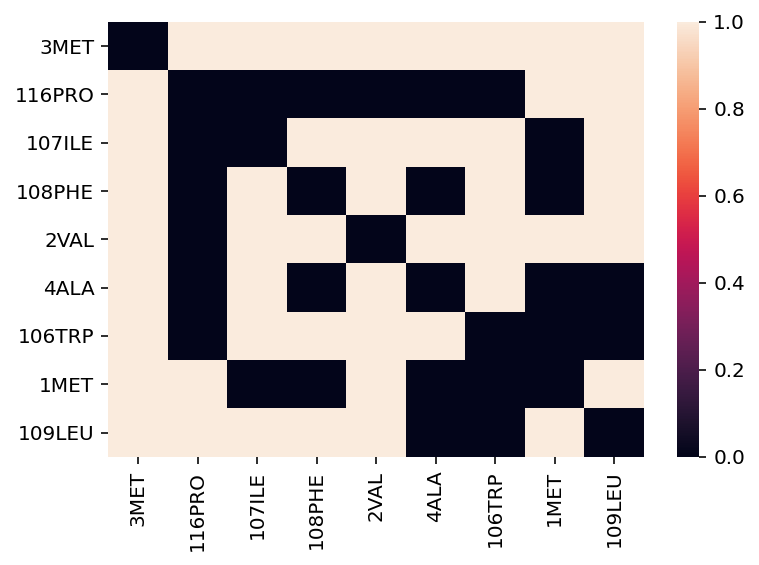

In [23]:
i= 1
labels = list(graphs[train_df["accession-sequence"].tolist()[1]].nodes())
num_nodes = len(labels)
plt.figure()
sns.heatmap(adj_matrix[i,:num_nodes,:num_nodes, :].squeeze(),
            xticklabels = labels, 
            yticklabels= labels)